In [12]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit 
using Plots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [13]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [14]:
function print_fit_values(fit, par0, par_names)
    println(@sprintf "RSS = %.5e (convergence: %s)" sum(abs2, fit.resid) fit.converged)
    for i in 1:length(par0)
        name = par_names[i]
        val = fit.param[i]
        CIl = confidence_interval(fit, 0.05)[i][1]
        CIr = confidence_interval(fit, 0.05)[i][2]
        p0 = par0[i]
        println(@sprintf "  %s = %.3e (CI=(%.3e, %.3e), initial=%.3e)" name val CIl CIr p0)
    end
end

print_fit_values (generic function with 1 method)

# Viral load data fitting

Macque data from

*Chandrashekar, A., Liu, J., Martinot, A. J., McMahan, K., Mercado, N. B., Peter, L., Tostanoski, L. H., Yu, J., Maliga, Z., Nekorchuk, M., Busman-Sahay, K., Terry, M., Wrijil, L. M., Ducat, S., Martinez, D. R., Atyeo, C., Fischinger, S., Burke, J. S., Slein, M. D., … Barouch, D. H. (2020). SARS-CoV-2 infection protects against rechallenge in rhesus macaques. Science, 817(August), eabc4776. https://doi.org/10.1126/science.abc4776*


## Data set



In [54]:
tdata = [1., 2., 4., 7., 10., 14., 21.]
data = readdlm("../../data/Chandrashekar2020/Group 1 (BAL).csv", ',', Float64, '\n', header=true)[1]
df = DataFrame(data, Symbol.(tdata))
# TODO: remove the "\ufeff" character at the start of the file from Windows

,1.0,2.0,4.0,7.0,10.0,14.0,21.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,8.4688,8.16525,6.23715,5.12414,3.3126,1.69897,1.69897
2,4.14981,5.00692,5.32055,2.65836,1.69897,1.69897,1.69897
3,6.26342,5.88252,3.67602,1.99093,1.69897,1.69897,1.69897


7-element Array{String,1}:
 &quot;\ufeff1&quot;
 &quot;2&quot;
 &quot;4&quot;
 &quot;7&quot;
 &quot;10&quot;
 &quot;14&quot;
 &quot;21&quot;

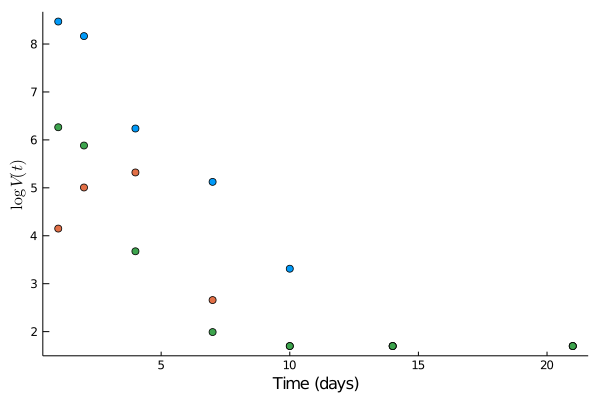

In [56]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[i, :], seriestype=:scatter) for i in 1:size(data, 1)]
plt

### Average of data

In [57]:
vdata_avg = mean(data, dims=1)[:]
vdata_std = std(data, dims=1)[:];

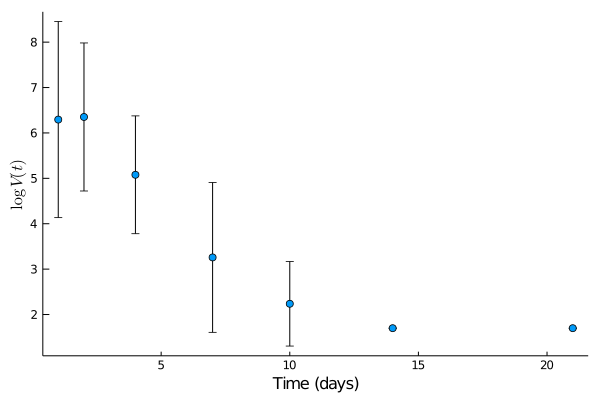

In [58]:
plot(tdata, vdata_avg, yerrors=vdata_std,
    seriestype=:scatter, legend=:none, grid=:off,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

### Combined data

In [73]:
ttdata = reshape(repeat(tdata', 3), 1, :)[:]
vvdata = reshape(data, 1, :)[:]

21-element Array{Float64,1}:
 8.4688
 4.149812
 6.263419
 8.165247
 5.006924
 5.882516
 6.237146
 5.320547
 3.676022
 5.124139
 2.658359
 1.990931
 3.312597
 1.69897
 1.69897
 1.69897
 1.69897
 1.69897
 1.69897
 1.69897
 1.69897

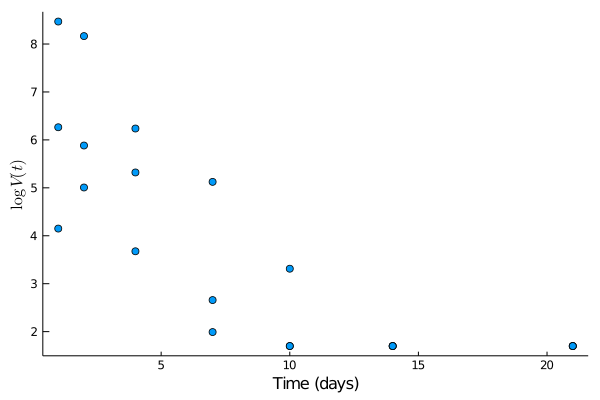

In [74]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

### Combined data omitting last 3 observations

In [81]:
ttdata = reshape(repeat(tdata[1:end]', 3), 1, :)[:]
tend = ttdata[end]
vvdata = reshape(data[:, 1:end], 1, :)[:];

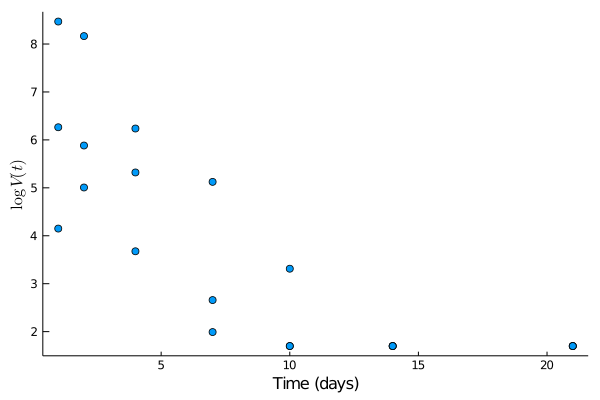

In [82]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

We'll use the combined data. But the average data shows similar results.

## Models

### Standard virus load function

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [83]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
v₁(t, a₁, a₂, logVmax) = 1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, logVmin) = 1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function VirusLoadFunction(t, p)
    a₁, a₂, b₁, b₂, α, logVmin, logVmax = p
    log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
end
namesVLF = ["a₁", "a₂", "b₁", "b₂", "α", "logVmin", "logVmax"];

### Standard virus-target ODE Model


The standard viral kinetic model with varying clearance rate reads
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


In [84]:
VirusTargetODE = @ode_def begin
    dT = -β*T*V
    dI₁ = β*T*V - k*I₁
    dI₂ = k*I₁ - δ*I₂/(K + I₂)
    dV = p*I₂ - c*V
end β k δ K p c;
u0 = [1e+7, 75.0, 0.0, 1e0]
tspan = (0.0, tend)
function VirusTargetModel(t, p)
    pars = (β = p[1], k = p[2], δ = p[3], K = p[4], p = p[5], c = p[6])
    prob = ODEProblem(VirusTargetODE, u0, tspan, pars)
    sol = solve(prob, Tsit5(), dtmax=1e-2)
    log10.(sol(t)[4, :])
end
namesVTM = ["β", "k", "δ", "K", "p", "c"];

## Fitting models to data

In [85]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.0,    5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -7.0,    4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.0,    7.0]
fitVLF = curve_fit(VirusLoadFunction, ttdata, vvdata, par0, lower=lb, upper=ub);

In [86]:
print_fit_values(fitVLF, par0, namesVLF)

RSS = 3.71821e+01 (convergence: false)


LinearAlgebra.LAPACKException: LinearAlgebra.LAPACKException(1)

In [ ]:
#       β     , k     , δ     , K     , p     , c
par0 = [2.5e-4, 1.5e+0, 1.6e+6, 5.0e+4, 2.1e+0, 1.5e+1]
lb   = [0.0,    0.0,    0.0,    0.0,    0.0,    0.0]
ub   = [Inf,    Inf,    Inf,    Inf,    Inf,    Inf]
fitVTM = curve_fit(VirusTargetModel, ttdata, vvdata, par0, lower=lb, upper=ub);

In [ ]:
print_fit_values(fitVTM, par0, namesVTM)

In [ ]:
tt = [range(0., tend, step=1e-2);]
pt = plot(ttdata, vvdata, seriestype=:scatter,
    label="Data set", grid=:off,
    xaxis = ("Time (days)", (0., 12.)),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
plot!(pt, tt, VirusLoadFunction(tt, fitVLF.param), lw=3, label="Virus load function")
plot!(pt, tt, VirusTargetModel(tt, fitVTM.param), lw=3, label="Virus-target model")
#savefig(figdir*"Smith2018DataFit.png")
#savefig(figdir*"Smith2018DataFit.pdf")
display(pt)